<a href="https://colab.research.google.com/github/Epatsili2000/ParkinsonDetection/blob/main/SplitDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Stratified Group Shuffle Split and File Organization

To prepare the dataset for model training and evaluation, we performed stratified group-wise splitting while ensuring **no speaker leakage** between splits.

#### Stratified Group Split
- Applied `GroupShuffleSplit` using:
  - `Label` as the stratification target
  - `Speaker_ID` as the grouping key (to avoid speaker overlap across splits)
- Split the dataset into:
  - **Train (64%)**
  - **Validation (16%)**
  - **Test (20%)**
- The split assignments were saved in `pcgita_split.csv`.

#### Split Distribution Plots
Two visualizations were generated:
- Sample count per split (`train`, `val`, `test`)
- Class distribution across splits (PD vs HC)

Saved under:

/PCGITA_RESULTS/plots/
├── split_count.png
└── label_distribution.png

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Saved stratified GroupShuffleSplit to: /content/drive/MyDrive/PCGITA_RESULTS/pcgita_split.csv
split
train    5217
test      692
val       503
Name: count, dtype: int64


/tmp/ipython-input-1-3359183642.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="split", palette="Set2")


📊 Saved split distribution plots to /content/drive/MyDrive/PCGITA_RESULTS/plots


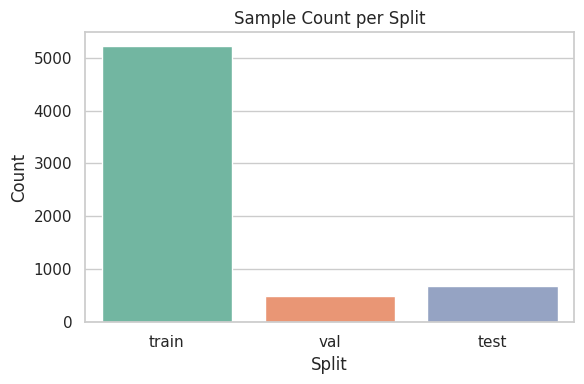

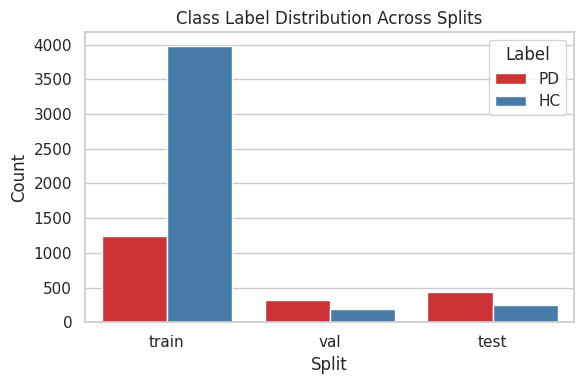

In [1]:
# -------------------- SETUP --------------------
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from shutil import copy2
from tqdm import tqdm

# -------------------- CONFIG --------------------
CSV_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_clean.csv"
OUT_SPLIT_CSV = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_split.csv"
PLOT_DIR = "/content/drive/MyDrive/PCGITA_RESULTS/plots"
DATA_ROOT = "/content/drive/MyDrive/PC-GITA_per_task_44100Hz/PC-GITA_per_task_44100Hz"

MOVE_FILES = False       # Set to True to organize .wav or .png into folders
FILE_TYPE = "wav"        # "wav" for audio, "png" for spectrograms
DST_ROOT = f"/content/drive/MyDrive/pcgita_images/{FILE_TYPE}_split"

os.makedirs(DST_ROOT, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------- LOAD DATA --------------------
df = pd.read_csv(CSV_PATH)
df["Speaker_ID"] = df["Speaker_ID"].astype(str).str.strip()
df["Label"] = df["Label"].str.upper().replace({"PARKINSON": "PD", "HEALTHY": "HC"})
df["filename"] = df["Full_Path"].apply(lambda x: os.path.basename(x))

# Sanity check
required_cols = ["Full_Path", "Label", "Task", "Speaker_ID"]
missing = [col for col in required_cols if col not in df.columns]
assert not missing, f"❌ Missing required columns: {missing}"

# -------------------- STRATIFIED GROUP SPLITTING --------------------
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(df, df["Label"], groups=df["Speaker_ID"]))

df["split"] = "test"
df.loc[train_idx, "split"] = "train"

# Further split train → train + val
train_df = df[df["split"] == "train"]
splitter_val = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_sub_idx, val_idx = next(splitter_val.split(train_df, train_df["Label"], groups=train_df["Speaker_ID"]))

df.loc[train_df.iloc[val_idx].index, "split"] = "val"
df.loc[train_df.iloc[train_sub_idx].index, "split"] = "train"

# -------------------- SAVE SPLIT FILE --------------------
df.to_csv(OUT_SPLIT_CSV, index=False)
print(f"✅ Saved stratified GroupShuffleSplit to: {OUT_SPLIT_CSV}")
print(df["split"].value_counts())

# -------------------- VISUALIZATION --------------------
sns.set(style="whitegrid")

# Count of samples per split
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="split", palette="Set2")
plt.title("Sample Count per Split")
plt.xlabel("Split")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/split_count.png")

# Class label distribution across splits
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="split", hue="Label", palette="Set1")
plt.title("Class Label Distribution Across Splits")
plt.xlabel("Split")
plt.ylabel("Count")
plt.legend(title="Label")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/label_distribution.png")

print(f"📊 Saved split distribution plots to {PLOT_DIR}")

# -------------------- OPTIONAL FILE COPYING --------------------
if MOVE_FILES:
    print("📦 Moving files into /train /val /test folders...")
    for _, row in tqdm(df.iterrows(), total=len(df)):
        src = row["Full_Path"]
        split = row["split"]
        label = row["Label"]
        task = row["Task"]
        speaker_id = row["Speaker_ID"]

        if not src.lower().endswith(FILE_TYPE):
            continue

        dst_dir = os.path.join(DST_ROOT, split, task, label, speaker_id)
        os.makedirs(dst_dir, exist_ok=True)

        dst_path = os.path.join(dst_dir, os.path.basename(src))
        try:
            copy2(src, dst_path)
        except Exception as e:
            print(f"⚠️ Failed to copy {src} → {e}")

    print(f"✅ Files organized in: {DST_ROOT}")


### Per-Task Stratified Group Splitting

In this step, we performed **stratified train/val/test splits separately for each speech task**, ensuring:
- Balanced PD/HC distribution per task
- No speaker overlap across splits

#### How it works:
- For each unique `task` (e.g., `monologue`, `ka-ka-ka`, etc.):
  - Group-wise train/test split using `GroupShuffleSplit` (80/20)
  - Then train/val split on the train portion (80/20 again)
- Speaker ID was used as the group identifier to prevent leakage.

#### Output:
The resulting DataFrame contains:
- `task`
- `label` (PD or HC)
- `speaker_id`
- `split` assignment: `train`, `val`, or `test`

Saved as:
 /PCGITA_RESULTS/pcgita_split_per_task.csv

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import GroupShuffleSplit

# -------------------- CONFIG --------------------
CSV_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_clean.csv"
OUTPUT_DIR = "/content/drive/MyDrive/PCGITA_RESULTS"

# -------------------- LOAD DATA --------------------
df = pd.read_csv(CSV_PATH)
df["speaker_id"] = df["Speaker_ID"].astype(str).str.strip()
df["task"] = df["Task"]
df["label"] = df["Label"].str.upper().replace({"PARKINSON": "PD", "HEALTHY": "HC"})

# -------------------- PER-TASK SPLITTING --------------------
per_task_dfs = []

for task in df["task"].unique():
    task_df = df[df["task"] == task].copy().reset_index(drop=True)
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(splitter.split(task_df, task_df["label"], groups=task_df["speaker_id"]))

    task_df["split"] = "test"
    task_df.loc[train_idx, "split"] = "train"

    train_df = task_df[task_df["split"] == "train"].copy().reset_index(drop=True)
    splitter_val = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_sub_idx, val_idx = next(splitter_val.split(train_df, train_df["label"], groups=train_df["speaker_id"]))

    # Fix reassignment of splits
    task_df.loc[task_df["split"] == "train", "split"] = "temp_train"
    task_df.loc[task_df["split"] == "temp_train", "split"] = "other"
    task_df.loc[train_df.index[train_sub_idx], "split"] = "train"
    task_df.loc[train_df.index[val_idx], "split"] = "val"

    per_task_dfs.append(task_df)

# -------------------- SAVE SPLIT --------------------
df_task_split = pd.concat(per_task_dfs, ignore_index=True)
per_task_split_path = os.path.join(OUTPUT_DIR, "pcgita_split_per_task.csv")
df_task_split.to_csv(per_task_split_path, index=False)
print(f"✅ Saved per-task GroupSplit to: {per_task_split_path}")
print(df_task_split["split"].value_counts())


✅ Saved per-task GroupSplit to: /content/drive/MyDrive/PCGITA_RESULTS/pcgita_split_per_task.csv
split
train    5217
other     676
val       503
test       16
Name: count, dtype: int64
